# Parking Space Detection Full Automatically



## Mount the google drive

In [ ]:
from google.colab import drive  
drive._mount('/content/drive')  

Mounted at /content/drive


## Installing Tensorflow and Keras Libraries
**Note**: Mask-RCNN is just compatible with 1.15 version of tensorflow and Keras version 2.1.6 

In [ ]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.1.6


     |████████████████████████████████| 411.5 MB 8.3 kB/s 
     |████████████████████████████████| 3.8 MB 39.8 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 503 kB 36.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f7afc5788b180c11603b68d6a38f7a3f7c3add10b8002c01c522b9849bb49a87
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.1.6 which is incompatible.
tensorflow 2.7.0 requires tensorboard~=2.6, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.7.0 requires tensorflow-estimator<2.8,~=2.7.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.


##Importing Required Modules
Importing some required libraries and also cloning the Mask-RCNN repository to my google drive 

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plot
from sklearn.cluster import DBSCAN
import random as rd
import sys

In [ ]:
import pickle
import argparse
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.widgets import PolygonSelector
from matplotlib.collections import PatchCollection
from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly

from shapely.geometry import Point


In [ ]:
# !git clone https://github.com/matterport/Mask_RCNN

import os
os.chdir("/content/drive/MyDrive/CV_project/Mask_RCNN/")
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [ ]:
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [ ]:
from pathlib import Path
from google.colab.patches import cv2_imshow
import pickle

from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
from IPython.display import clear_output, Image, display, HTML
import io
import base64
%matplotlib inline

## Defining Some Function For Image Processing With Open-CV

### Function of thresholdImage 
It takes each channel of the empty parking lot image and compares each pixel with the same channel on the full park. If the differences was more than the threshold, then the pixel is considered as a car pixel and the pixel on the same position in the binary image "res" is painted black. This allows to recognize cars of almost any color.

**Note:** the cars with intensities similar to the background are hard to paint. :(


In [ ]:
# function to get the each image channels 
def getChannels(img):
	return img[:,:,2],img[:,:,1],img[:,:,0]

def thresholdImage(gray,thr,block_size=None,img=None):
	rows,col = img[:,:,0].shape
	r1,g1,b1 = getChannels(gray) 
	r2,g2,b2 = getChannels(img)
	res = np.zeros((rows,col))
	for i in range(0,rows):
		for j in range(0,col):
			rDif = abs(int(r1[i,j]) - int(r2[i,j]))
			gDif = abs(int(g1[i,j]) - int(g2[i,j]))
			bDif = abs(int(b1[i,j]) - int(b2[i,j]))
			if rDif >= thr or gDif >= thr or bDif >= thr:
				res[i,j] = 0
			else:
				res[i,j] = 255
	return res

In [ ]:
def getEdges(gray,min_thr=None,max_thr=None):	
	return cv2.Canny(gray,min_thr,max_thr) 

**Note :** This function leads to have an image which all edges are detected. I chose **Canny Edge Detection**, because 
it first removes noise from image by **Smoothening**. It then finds the image gradient to highlight regions with high spatial derivatives.

### Using **DBSCAN** Clustring Algorithm 
**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)** is a base algorithm for density-based clustering. It can discover clusters of different shapes and sizes from a large amount of data, which is containing noise and outliers.


In [ ]:
def dbscan(points,eps,min_samples):
	# eps=5 min_samples = 80
	db = DBSCAN(eps=eps, min_samples=min_samples).fit(points) 
	# Labeling pixels by cluster
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True
	labels = db.labels_
	# Number of clusters in labels, ignoring noise if present.
	n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
	# Creating list of clusters
	return [points[labels == i] for i in range(n_clusters_)]



#function to get the center point of each cluster 
def getCentroids(clusters,img):
	n = 0
	# centroid will store the coordinates of the center of each cluster 
	centroids = np.zeros((len(clusters),2),dtype=np.int_)
	for c in clusters:
		x,y = (int(sum(c[:,0])/len(c[:,0])),int(sum(c[:,1])/len(c[:,1])))
		r,g,b = rd.randint(0,255),rd.randint(0,255),rd.randint(0,255)
		centroids[n,0],centroids[n,1] = x,y
		n = n + 1
		cv2.circle(img,(y,x),7,(r,g,b),-1)
	return centroids,img


# function to visualize the centroid of each cluster by a point 
def paintClusters(img,clusters):
	# Painting clusters
	for c in clusters:
		r,g,b = rd.randint(0,255),rd.randint(0,255),rd.randint(0,255)
		for pixel in c:
			img[int(pixel[0]),int(pixel[1]),:] = b,g,r
	return img
		

## Extracting centeroid of each parking lot

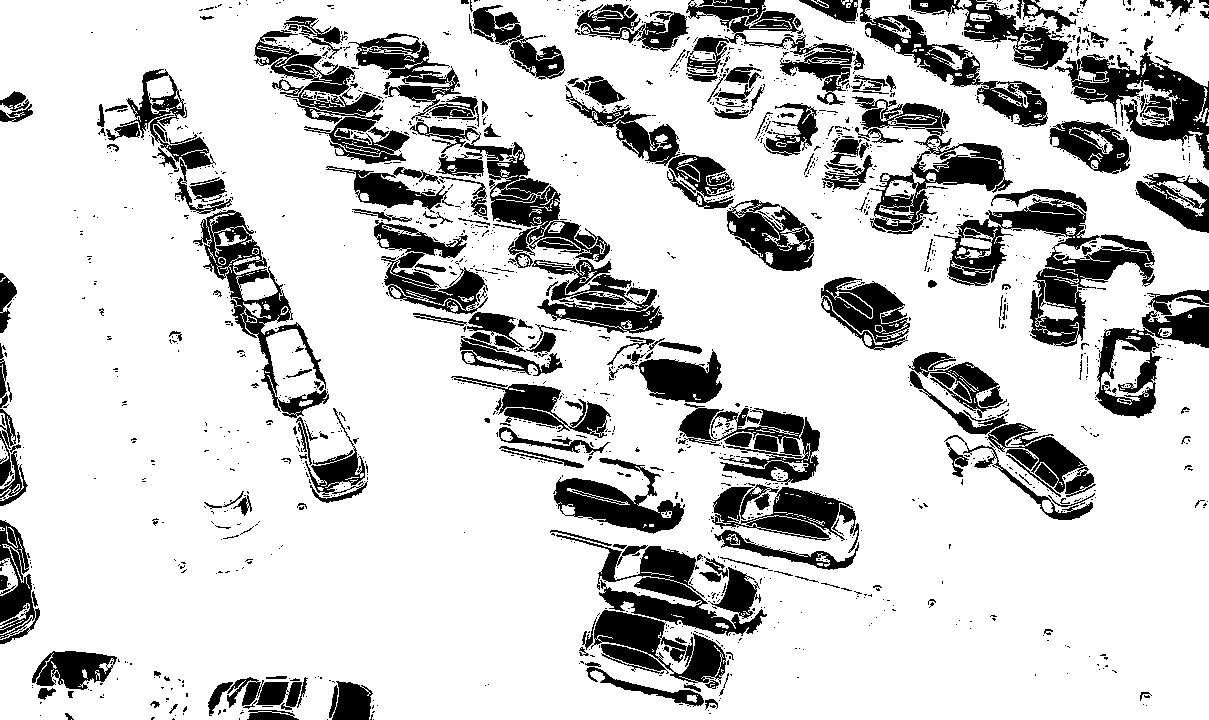

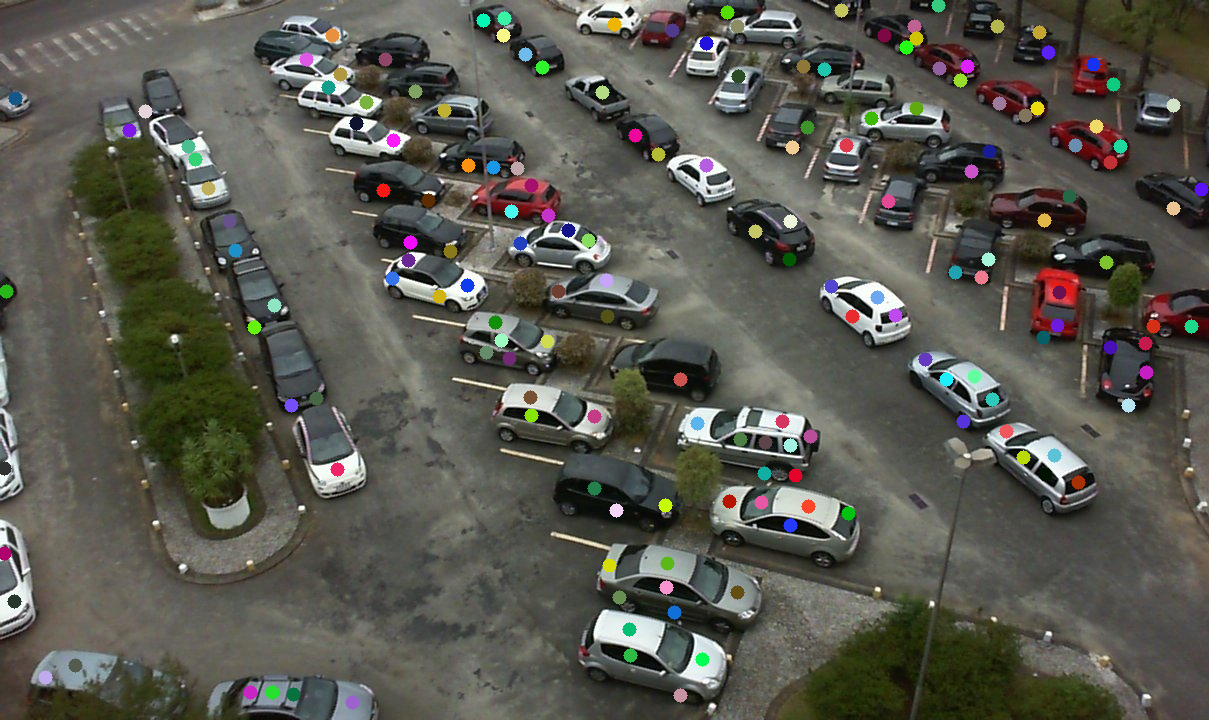

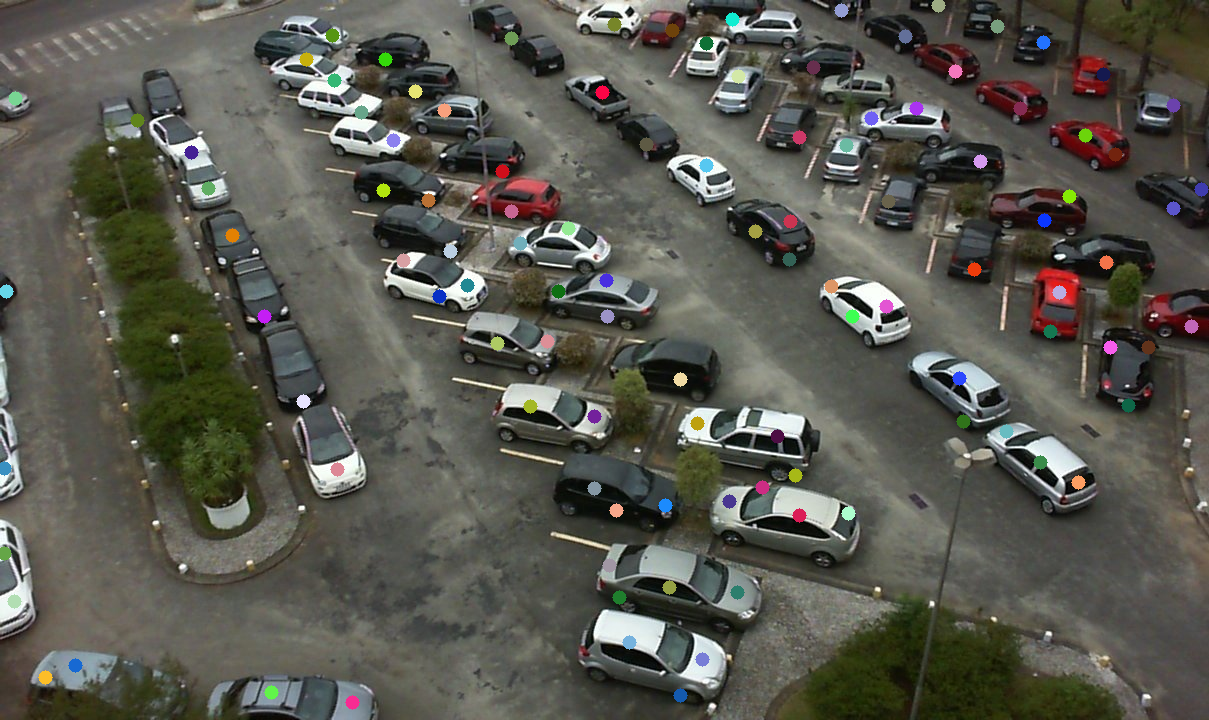

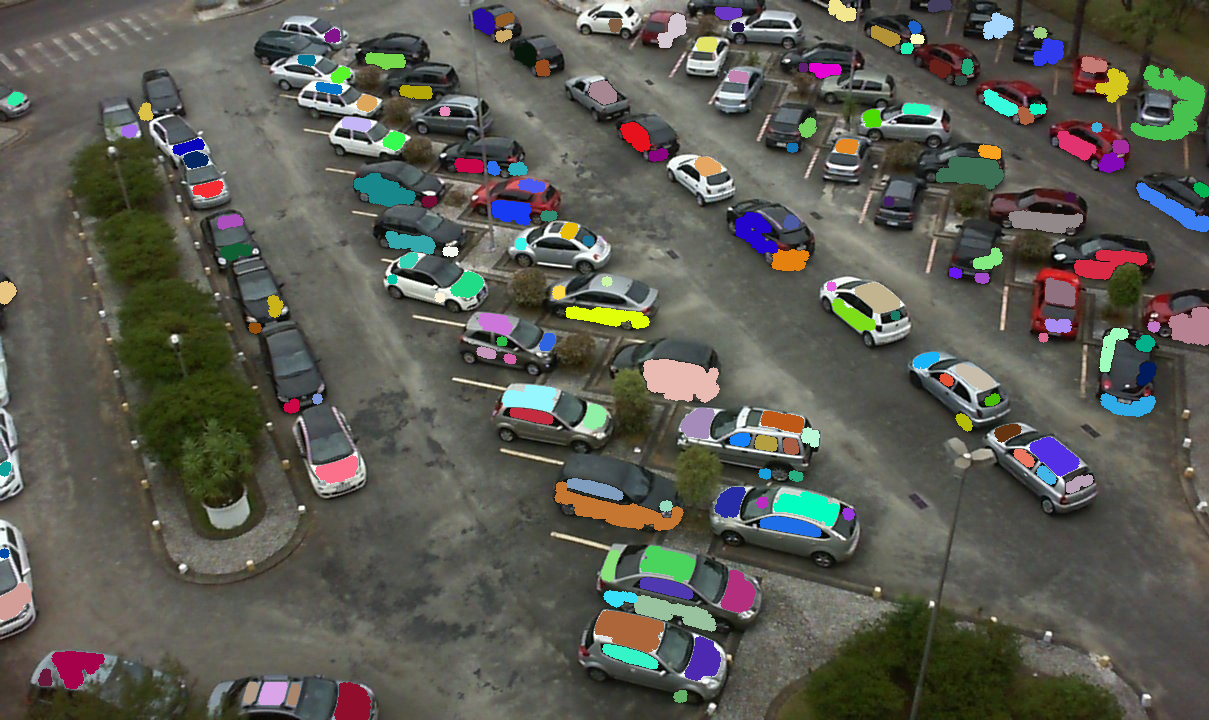

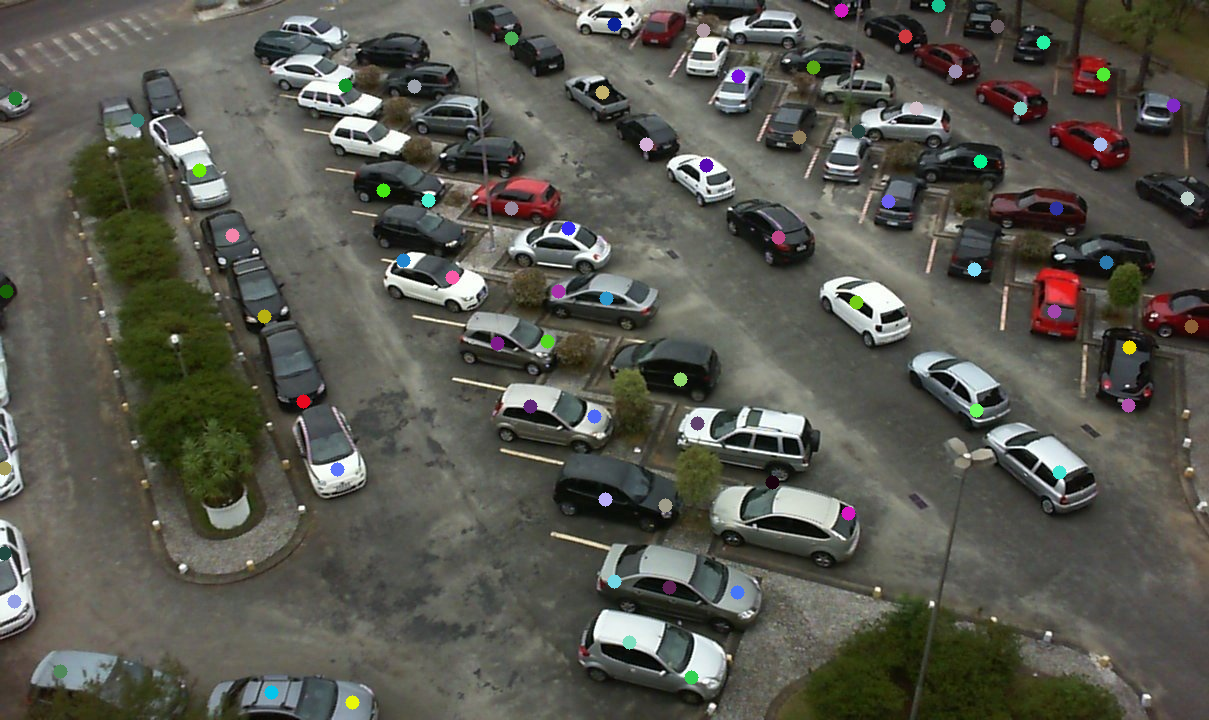

In [ ]:
# Completely empty and completely full parking lot images
img1 = cv2.imread("/content/drive/MyDrive/CV_project/Empty.jpeg")
img2 = cv2.imread("/content/drive/MyDrive/CV_project/Full.jpeg")
if img1 is None or img2 is None:
  print("The entered paths are not correct, Please check the paths again.")
  sys.exit()

# Blurring empty parking lot image with Gaussian 
blur = cv2.GaussianBlur(img1,(7,7),0)

# Dimensions of the image
rows,col = img1[:,:,0].shape

# Coying Images for having results as image (res = result)
res2 = img2.copy()
res3 = img2.copy()
res4 = img2.copy()
res5 = img2.copy()
res6 = img2.copy()


# Grayscaling the image of the full parking lot
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

# Edges on full parking lot using Canny edge detector 
edges = getEdges(gray,50,200)

# Threshold for every channel
threshold = 40

cars = np.zeros((rows,col))
cars = thresholdImage(img2,threshold,img=blur)

# Adding edges to the thresholded image to separate cars
cars = cars + edges



# Getting indeces of car or black pixels on cars
cars_pixels = np.where(cars == 0)
# Number of car pixels
num_pix = cars_pixels[0].size

cord_pix = np.zeros((num_pix,2)) 

# Putting coordinates of pixels in cord_pix
for i in range(0,num_pix):
  cord_pix[i,:] = [cars_pixels[0][i],cars_pixels[1][i]]

# Applying dbscan clustering to cord_pix  
  # where:
            # eps: distance from current centroid to others
            # min_samples: min number of pixels that must be at a distance of less or equal than eps
          # to consider the current pixel as a centroid
eps = 5
min_samples = 80

clusters = dbscan(X,eps,min_samples)

# Centroids stores the coordinates of the center of each cluster and rest2 is the image to visualize
centroids,res2 = getCentroids(clusters,res2)

if centroids.size == 0:
  print("No clusters were created. Please change dbscan parameters.")
  sys.exit()

# trying to cluster the centroids again
eps2 = 30
min_samples2 = 1

clusters2 = dbscan(centroids,eps2,min_samples2)

# centroid will store the coordinates of the center of each cluster 
centroids2,res3 = getCentroids(clusters2,res3)

# trying to cluster the centroids for the third time
eps3 = 45
min_samples3 = 1

# creating list of clusters
clusters3 = dbscan(centroids2,eps3,min_samples3)

# centroid will store the coordinates of the center of each cluster 
centroids3,res5 = getCentroids(clusters3,res5)

# Painting clusters
res4 = paintClusters(res4,clusters)




# # trying to cluster the centroids again
# eps4 = 60
# min_samples4 = 1

# # Creating list of clusters
# clusters4 = dbscan(centroids3,eps4,min_samples4)

# # centroid will store the coordinates of the center of each cluster 
# centroids4,res6 = getCentroids(clusters4,res6)
cv2_imshow(cars)
cv2_imshow(res2)
cv2_imshow(res3)
cv2_imshow(res4)
cv2_imshow(res5)
# cv2_imshow(res6)


cv2.waitKey(0)
cv2.destroyAllWindows()


## Creating box for each parking lot

In [ ]:
Array = [(i[1], i[0]) for i in centroids3]
Array

[(841, 10),
 (938, 5),
 (703, 30),
 (511, 38),
 (997, 26),
 (614, 24),
 (905, 36),
 (1043, 42),
 (345, 85),
 (414, 86),
 (1103, 74),
 (955, 71),
 (813, 67),
 (1173, 105),
 (738, 76),
 (602, 92),
 (1020, 108),
 (15, 98),
 (137, 120),
 (916, 108),
 (858, 131),
 (799, 137),
 (646, 144),
 (1100, 144),
 (199, 170),
 (980, 161),
 (706, 165),
 (511, 208),
 (383, 190),
 (1187, 198),
 (1056, 208),
 (428, 200),
 (888, 201),
 (568, 228),
 (778, 237),
 (232, 235),
 (403, 260),
 (452, 277),
 (974, 269),
 (1106, 262),
 (606, 298),
 (1054, 311),
 (6, 291),
 (856, 302),
 (558, 291),
 (264, 316),
 (1191, 326),
 (497, 343),
 (1129, 347),
 (547, 341),
 (976, 410),
 (680, 379),
 (530, 406),
 (303, 401),
 (1128, 405),
 (594, 416),
 (697, 423),
 (772, 482),
 (1059, 472),
 (337, 469),
 (4, 468),
 (605, 499),
 (665, 505),
 (848, 513),
 (669, 587),
 (4, 553),
 (614, 581),
 (737, 592),
 (14, 601),
 (629, 642),
 (691, 677),
 (60, 671),
 (271, 692),
 (352, 702)]

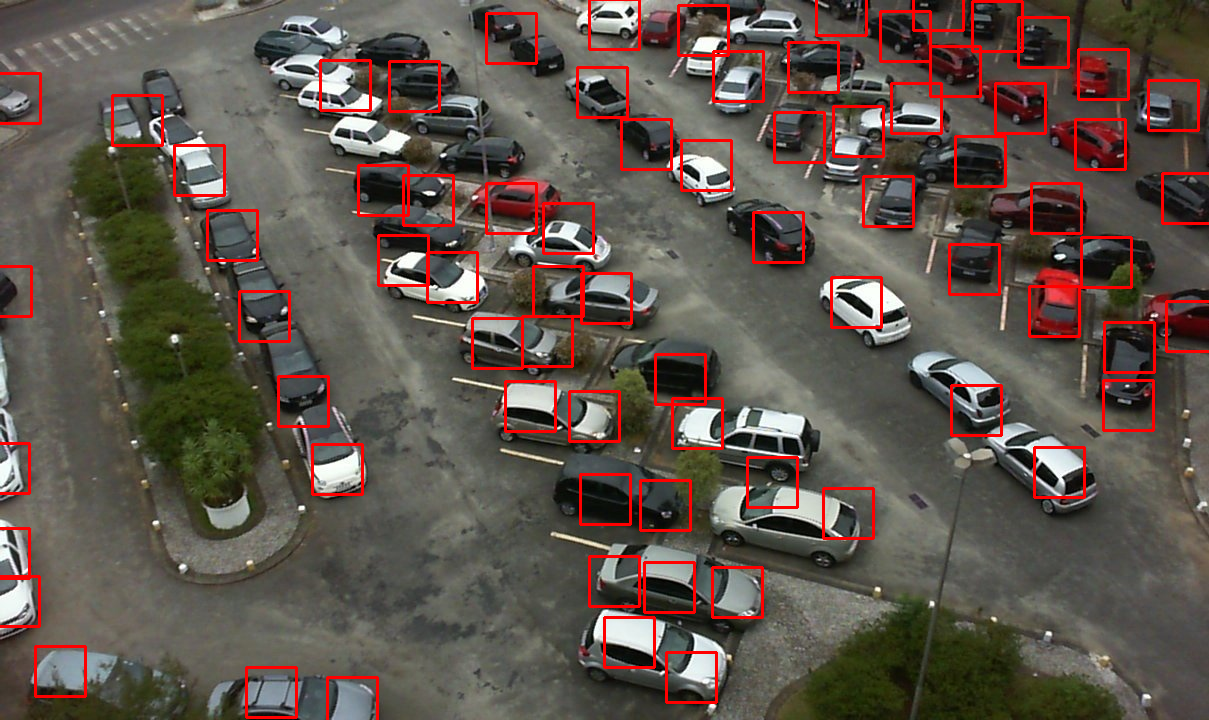

In [ ]:
# Reading an image in default mode
image = cv2.imread('/content/drive/MyDrive/CV_project/Full.jpeg')

# Window name in which image is displayed
window_name = 'Image'

# Blue color in BGR
color = (0, 0, 255)

# Line thickness of 2 px
thickness = 2
for i in range(len(Array)):

  # Start coordinate, here (5, 5)
  # represents the top left corner of rectangle
  start_point = (Array[i][0]-25, Array[i][1]+25)

  # Ending coordinate, here (220, 220)
  # represents the bottom right corner of rectangle
  end_point = (Array[i][0]+25, Array[i][1]-25)


# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
  image = cv2.rectangle(image, start_point, end_point, color, thickness)

# Displaying the image
cv2_imshow(image)




## Extracting the coordinates of each box as Polygon 

In [ ]:
def function(x, y):
  return np.array([[x-25 , y+25], [x -25, y - 25], [x+25, y+25], [x + 25, y - 25]], dtype = 'int32')
Polygan_points = list(map(lambda x: function(x[0], x[1]), Array))

In [ ]:
Polygan_points

[array([[816,  35],
        [816, -15],
        [866,  35],
        [866, -15]], dtype=int32), array([[913,  30],
        [913, -20],
        [963,  30],
        [963, -20]], dtype=int32), array([[678,  55],
        [678,   5],
        [728,  55],
        [728,   5]], dtype=int32), array([[486,  63],
        [486,  13],
        [536,  63],
        [536,  13]], dtype=int32), array([[ 972,   51],
        [ 972,    1],
        [1022,   51],
        [1022,    1]], dtype=int32), array([[589,  49],
        [589,  -1],
        [639,  49],
        [639,  -1]], dtype=int32), array([[880,  61],
        [880,  11],
        [930,  61],
        [930,  11]], dtype=int32), array([[1018,   67],
        [1018,   17],
        [1068,   67],
        [1068,   17]], dtype=int32), array([[320, 110],
        [320,  60],
        [370, 110],
        [370,  60]], dtype=int32), array([[389, 111],
        [389,  61],
        [439, 111],
        [439,  61]], dtype=int32), array([[1078,   99],
        [1078,   49],


In [ ]:
#creat the pickle file as input of approach one 
with open('new_region13.p', 'wb') as f:
  pickle.dump(Polygan_points, f, protocol=pickle.HIGHEST_PROTOCOL)
  # exit()

## Configuring M-RCNN
All the process are the same as before

In [ ]:
class Config(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 81


config = Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
ROOT_DIR = Path(".")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=Config())







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
# #  This will contain test videos and images
# if not os.path.exists("./sh"):
#     os.makedirs("./sh")
!rm -r sh
!mkdir sh

rm: cannot remove 'sh': No such file or directory


In [ ]:
VIDEO_SOURCE = "/content/drive/MyDrive/CV_project/2013-03-15_07_40_02.jpg"
PARKING_REGIONS = "/content/drive/MyDrive/CV_project/Mask_RCNN/new_region13.p"
with open(PARKING_REGIONS, 'rb') as f:
    parked_car_boxes = pickle.load(f)

In [ ]:
# COCO predefined classes

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / bus / truck, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

In [ ]:
def compute_overlaps(parked_car_boxes, car_boxes):
    
    new_car_boxes = []
    for box in car_boxes:
        y1 = box[0]
        x1 = box[1]
        y2 = box[2]
        x2 = box[3]
        
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4])
    
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes)))
    for i in range(len(parked_car_boxes)):
        for j in range(car_boxes.shape[0]):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy).buffer(0.001)
            polygon2_shape = shapely_poly(pol2_xy).buffer(0.001)

            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
            polygon_union = polygon1_shape.union(polygon2_shape).area
            IOU = polygon_intersection / polygon_union
            overlaps[i][j] = IOU

    return overlaps

In [ ]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

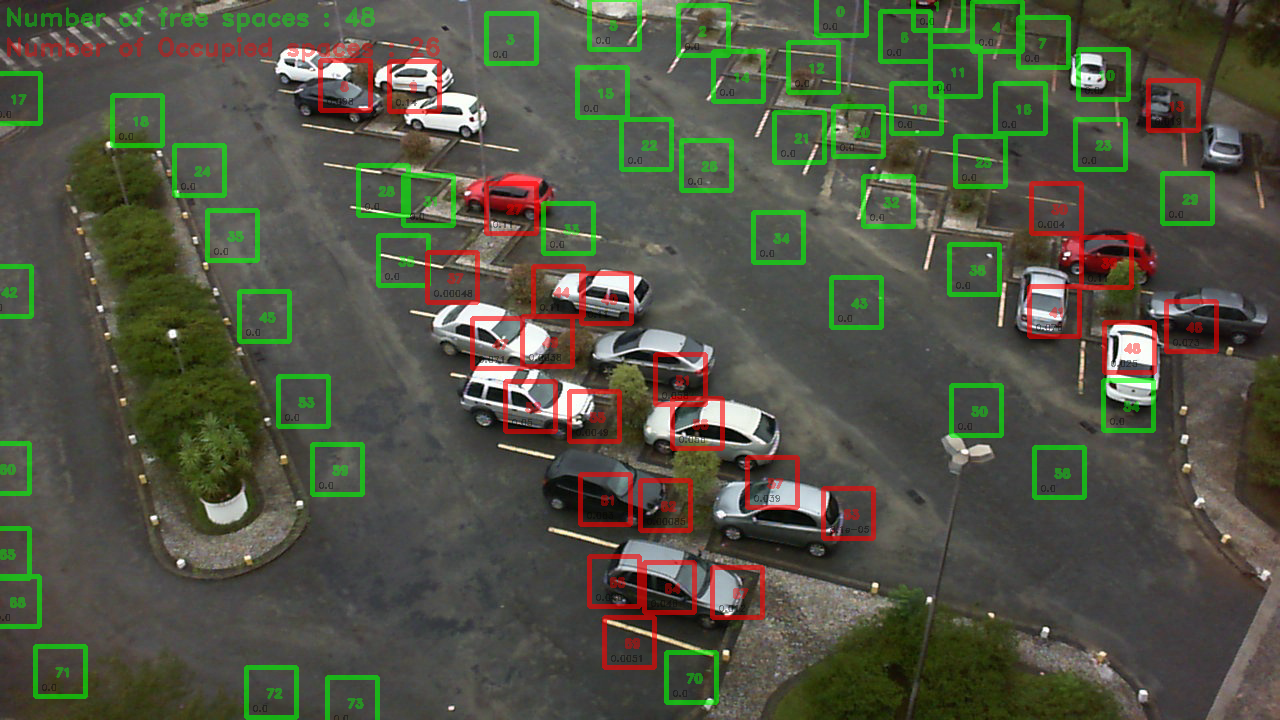

AttributeError: ignored

In [ ]:
alpha = 0.6
video_capture = cv2.VideoCapture(VIDEO_SOURCE)
cnt=0

video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
video_fps       = video_capture.get(cv2.CAP_PROP_FPS)
video_size      = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter("testout.avi", video_FourCC, video_fps, video_size)

while video_capture.isOpened():
    Empty = 0
    Occupied = 0
    success, frame = video_capture.read()
    overlay = frame.copy()
    if not success:
        break

    rgb_image = frame[:, :, ::-1]
    results = model.detect([rgb_image], verbose=0)

    car_boxes = get_car_boxes(results[0]['rois'], results[0]['class_ids'])
    overlaps = compute_overlaps(parked_car_boxes, car_boxes)

    slot = []
    font = cv2.FONT_HERSHEY_DUPLEX 
    number = 0

    for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
      
      x1, y1 = parking_area[0]
      x2, y2 = parking_area[1]
      x3, y3 = parking_area[2]
      x4, y4 = parking_area[3]

      fx1 = min(x1,x2,x3,x4)
      fx2 = max(x1,x2,x3,x4)
      fy1 = min(y1,y2,y3,y4)
      fy2 = max(y1,y2,y3,y4)
      
      #print(parking_area.shape[0])

      max_IoU_overlap = np.max(overlap_areas)
      if max_IoU_overlap < 0.00000000000001:
        cv2.rectangle(overlay, (fx1, fy1), (fx2, fy2), (0, 255, 0), 3)
        cv2.putText(frame,  str(number), (fx1 + 20, fy2 - 20), font, 0.4, (0, 255, 0), 2, cv2.FILLED)
        number = number + 1  
        #free_space = True
        slot.append(1) 
      else:
        cv2.rectangle(overlay, (fx1, fy1), (fx2, fy2), (0, 0, 255), 3)
        cv2.putText(frame,  str(number), (fx1 + 20, fy2 - 20), font, 0.4, (0, 0, 255), 2, cv2.FILLED)
        number = number + 1 
        slot.append(0)  
      cv2.putText(frame, f"{max_IoU_overlap:0.2}", (fx1 + 6, fy2 - 6), font, 0.3, (0, 0, 0))  
    
    for i in range(0,len(slot)):
      if slot[i] == 1:
        Empty+=1
        print(i, "FREE")
      else:
        Occupied+=1
        print(i, "NOT FREE")
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(frame, "Number of free spaces : %s" %Empty, (5, 25), font, 0.8, (0, 255, 0), 2, cv2.FILLED)
    cv2.putText(frame, "Number of Occupied spaces : %s" %Occupied, (5, 55), font, 0.8, (0, 0, 255), 2, cv2.FILLED)
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    out.write(frame)

    clear_output(wait=True)
    img = arrayShow(frame)
    display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
out.release()
cv2.destroyAllWindows()